# MODS Phenotypes: Step 4. Grady Create Study Cohorts

## Setup

### `imports`

In [1]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
from datetime import date
from multiprocessing import Pool
from IPython.display import display as display

from tqdm.auto import tqdm
tqdm(total=100, mininterval=1.0)

  0%|          | 0/100 [00:00<?, ?it/s]

In [2]:
site_name = 'grady'

sys.path.insert(0, "/opt/scratchspace/KLAB_SAIL/MODSPhenotypes/mods/")
from src.config import *
from src.utils import *
from src.analysis import *

### `config`

In [3]:
# TODO: this shouldnt be needed make it go away

years=['2016','2017','2018','2019','2020']

sepsis3_window_days = project_config['parameters']['sepsis3_window_days']
num_cpus = project_config['parameters']['num_cpus']
num_gpus = project_config['parameters']['num_gpus']


patient_id = project_config[site_name]["keys"]["patient_key"]
service_id = project_config[site_name]["keys"]["service_key"]
record_dt = project_config[site_name]["keys"]["record_dt"]


scores_keys = project_config[site_name]["scores"]
static_keys = project_config[site_name]["static"]
dynamic_keys = project_config[site_name]["dynamic"]
times_keys = project_config[site_name]["times"]
datetimes_keys = project_config[site_name]["datetimes"]


hospital_intime = project_config[site_name]["datetimes"]["hospital_intime"]
hospital_outtime = project_config[site_name]["datetimes"]["hospital_outtime"]
hospital_encounter_current = project_config[site_name]["datetimes"]["hospital_encounter_current"]
hospital_encounter_total = project_config[site_name]["datetimes"]["hospital_encounter_total"]

sepsis3_current = 'sepsis3_current'
hours_after_sepsis = 'hours_after_sepsis'
sepsis3_onset = project_config[site_name]["datetimes"]["sepsis3_onset"]
sepsis3_encounter = project_config[site_name]['datetimes']['sepsis3_encounter']
sepsis3_config = project_config[site_name]['datetimes']['sepsis3_current']
sepsis3_window = project_config[site_name]['datetimes']['sepsis3_window']

In [4]:
sofa_organ_cols = [
    'SOFA_coag',
    'SOFA_renal',
    'SOFA_hep',
    'SOFA_neuro',
    'SOFA_cardio',
    'SOFA_resp'
]

sofa_score_cols = [f"{col}_score" for col in sofa_organ_cols]
sofa_failure_cols = [f"{col}_failure" for col in sofa_organ_cols]
sofa_status_cols = sofa_failure_cols + ['SOFA_no_failure']

sofa_etc_cols = [
    'SOFA_cardio_mod',
    'SOFA_resp_sa',
    'SOFA_hourly_total',
    'SOFA_hourly_total_mod',
    'SOFA_delta_24h',
    'SOFA_delta_24h_mod'
]

sofa_cols = sofa_organ_cols + sofa_score_cols + sofa_failure_cols + sofa_status_cols + sofa_etc_cols

sepsis_cols = [
'first_sep3_SOFA',
'first_sep3_time',
'first_sep3_susp_mod',
'first_sep3_SOFA_mod',
'first_sep3_time_mod'
]

time_col = 'time_1D'
mods_label = 'mods_28D'

sofa_admission_failure_cols = [f"{col}_admission" for col in sofa_failure_cols]


### `duckdb()`

In [5]:
import duckdb
import sqlalchemy
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [6]:
%%sql
duckdb:////opt/scratchspace/KLAB_SAIL/MODSPhenotypes/data/MODS.duckdb
PRAGMA memory_limit='700GB';
PRAGMA threads=180;
PRAGMA enable_profiling;
PRAGMA enable_optimizer;
PRAGMA temp_directory='/opt/localdata/duck.tmp'

""


In [7]:
%sql SET access_mode TO 'READ_ONLY';

""


### Modin

In [8]:
%%time
ray_path = Path("/opt/localdata/ray")
temp_dir = ray_path / "temp"
temp_dir.mkdir(exist_ok=True, parents=True)

import ray
ray.init(
    num_cpus=num_cpus,
    num_gpus=num_gpus,
    include_dashboard=False,
    _temp_dir=str(temp_dir),
)

import modin.pandas as md

CPU times: user 556 ms, sys: 245 ms, total: 801 ms
Wall time: 4.5 s


## 28 DAYS POST SEPSIS
Find patients with sepsis who developed MODS within 28 days of sepsis-onset

In [39]:
%%time
%%sql
sepsis_28D_df_pd << SELECT      {patient_id},
                                {service_id},
                                {hospital_encounter_current},
                                admission_year,
                                hours_after_sepsis,
                                SOFA_coag,
                                SOFA_renal,
                                SOFA_hep,
                                SOFA_neuro,
                                SOFA_cardio,
                                SOFA_cardio_mod,
                                SOFA_resp,
                                SOFA_resp_sa,
                                SOFA_hourly_total,
                                SOFA_delta_24h,
                                SOFA_hourly_total_mod,
                                SOFA_delta_24h_mod,
                                first_sep3_SOFA,
                                first_sep3_time,
                                first_sep3_susp_mod,
                                first_sep3_SOFA_mod,
                                first_sep3_time_mod
                                FROM {site_name}_sepsis_28days
                                    WHERE admission_year IN (2016,2017,2018,2019,2020);

Returning data to local variable sepsis_28D_df_pd
CPU times: user 35.5 s, sys: 3 s, total: 38.5 s
Wall time: 38.1 s


In [40]:
##### Move from Pandas to Modin
sepsis_28D_df = md.DataFrame(sepsis_28D_df_pd)
# del(sepsis_28D_df_pd)

In [41]:
##### Sort and Index
sepsis_28D_df.sort_values([service_id, hospital_encounter_current], ascending=True, inplace=True)
sepsis_28D_df.set_index([service_id], inplace=True)

In [42]:
##### Normalize SOFA Scores
sepsis_28D_df = normalize_sofa_scores(sepsis_28D_df, cols=sofa_organ_cols)

### MODS_28D

In [43]:
##### For each CSN, find the maximum SOFA score for each organ over the 28 days
max_sofa_scores_28D = sepsis_28D_df[sofa_score_cols].groupby(service_id).max()

In [44]:
##### Determine which organs have failed
max_sofa_scores_28D = sofa_status_check(max_sofa_scores_28D, sofa_score_cols, sofa_failure_cols)

In [45]:
##### Get a list of service IDs for encounters that had MODS within 28 days of sepsis-onset
serviceIDs_mods_28D = max_sofa_scores_28D.query("SOFA_no_failure != True").index

##### Plot

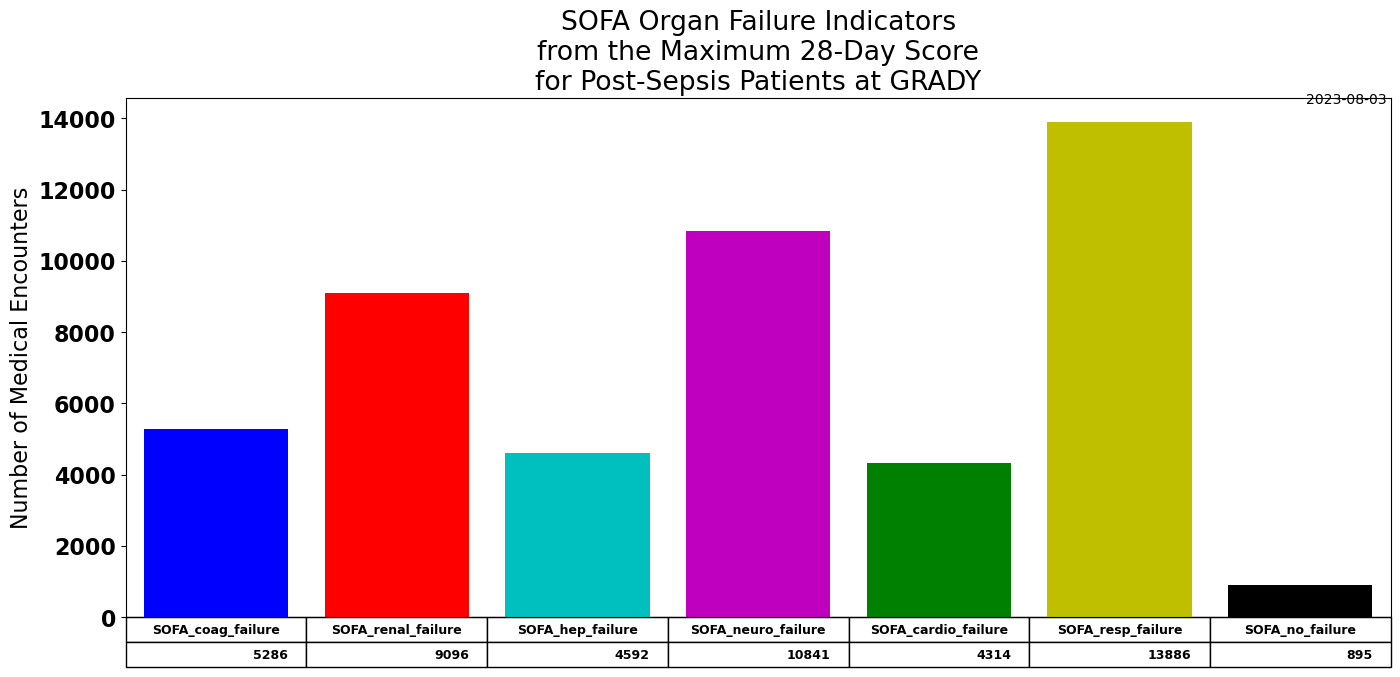

In [71]:
plt_title = (
f"""SOFA Organ Failure Indicators
from the Maximum 28-Day Score
for Post-Sepsis Patients at {site_name.upper()}"""
)
plot_sofa_status(df=max_sofa_scores_28D[sofa_status_cols], title=plt_title)

Count of number of organs which went into failure 28 days post sespsi

In [47]:
cohort_df = max_sofa_scores_28D[max_sofa_scores_28D[sofa_status_cols[:-1]].sum(axis=1) >= 2]

In [48]:
##### Export
cohort_df.to_parquet(project_path/'data'/run_id/f"{site_name}_cohort_df_{run_id}.parquet")

In [49]:
organs_failed_counts = max_sofa_scores_28D[sofa_status_cols[:-1]].sum(axis=1).value_counts()

In [50]:
organs_failed_counts.sort_index(inplace=True)

In [51]:
labels, data = organs_failed_counts.index, organs_failed_counts.values
labels = [f"{n}" for n in labels]

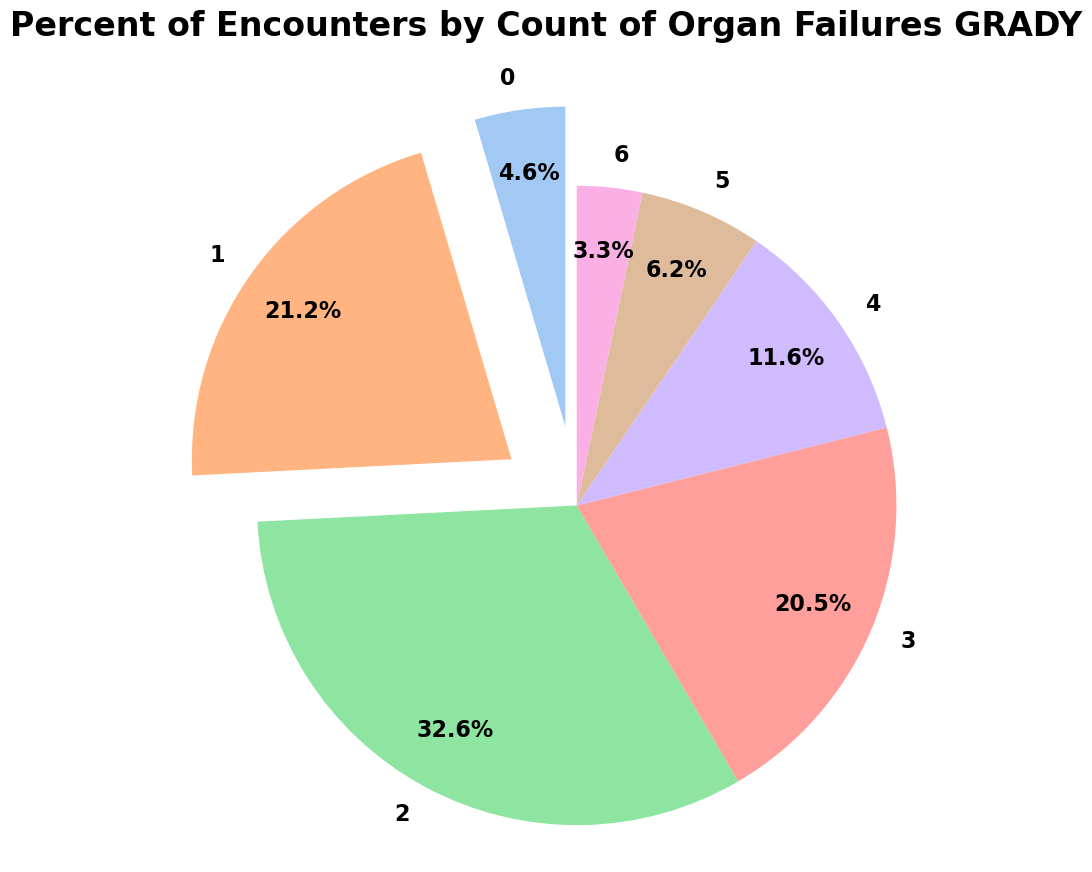

In [72]:
##### Define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:8]

explode = [0 for _ in labels]
explode[list(labels).index('0')] = 0.25
explode[list(labels).index('1')] = 0.25

fig, ax = plt.subplots()
fig.set_size_inches(11, 9)
ax.pie(data, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors,
        pctdistance=0.8, labeldistance=1.1)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title(f"Percent of Encounters by Count of Organ Failures {site_name.upper()}", size=24, fontweight="bold", pad=25)
plt.tight_layout()
plt.show()

## AT TIME OF ADMISSION
For patients who developed MODS, determine what their MODS status was at the time of admission

#### Data

In [53]:
%%time
%%sql
sepsis_admission_df_pd << SELECT    {patient_id},
                                    {service_id},
                                    {hospital_encounter_current},
                                    admission_year,
                                    hours_after_sepsis,
                                    SOFA_coag,
                                    SOFA_renal,
                                    SOFA_hep,
                                    SOFA_neuro,
                                    SOFA_cardio,
                                    SOFA_cardio_mod,
                                    SOFA_resp,
                                    SOFA_resp_sa,
                                    SOFA_hourly_total,
                                    SOFA_delta_24h,
                                    SOFA_hourly_total_mod,
                                    SOFA_delta_24h_mod,
                                    first_sep3_SOFA,
                                    first_sep3_time,
                                    first_sep3_susp_mod,
                                    first_sep3_SOFA_mod,
                                    first_sep3_time_mod
                        FROM {site_name}_sepsis_admission
                                    WHERE admission_year IN (2016,2017,2018,2019,2020);

Returning data to local variable sepsis_admission_df_pd
CPU times: user 169 ms, sys: 89.6 ms, total: 259 ms
Wall time: 143 ms


In [54]:
##### Move dataframe into Modin
sepsis_admission_df = md.DataFrame(sepsis_admission_df_pd)

#### MODS_28D

In [55]:
# Check the organ status at admission for encounters which had developed MODS within 28 days of sepsis-onset
sepsis_admission_df.query(f"{service_id} in @serviceIDs_mods_28D.tolist()", inplace=True)

#### Sort and Index

In [56]:
sepsis_admission_df.sort_values([service_id, hospital_encounter_current], ascending=True, inplace=True)
sepsis_admission_df.set_index([service_id], inplace=True)

#### Normalize

In [57]:
sepsis_admission_df = normalize_sofa_scores(sepsis_admission_df, cols=sofa_organ_cols)

#### Check Status

In [58]:
sepsis_admission_df = sofa_status_check(sepsis_admission_df, sofa_score_cols, sofa_failure_cols)

In [59]:
sepsis_admission_status = sepsis_admission_df[sofa_status_cols].add_suffix('_admission')

In [60]:
sepsis_admission_status.head()

,SOFA_coag_failure_admission,SOFA_renal_failure_admission,SOFA_hep_failure_admission,SOFA_neuro_failure_admission,SOFA_cardio_failure_admission,SOFA_resp_failure_admission,SOFA_no_failure_admission
csn,,,,,,,
1015752680,False,False,True,False,False,False,False
1015788298,False,False,True,False,False,False,False
1015788546,False,False,True,False,False,False,False
1015788896,False,False,True,False,False,False,False
1015789329,False,False,True,False,False,False,False


#### Plot

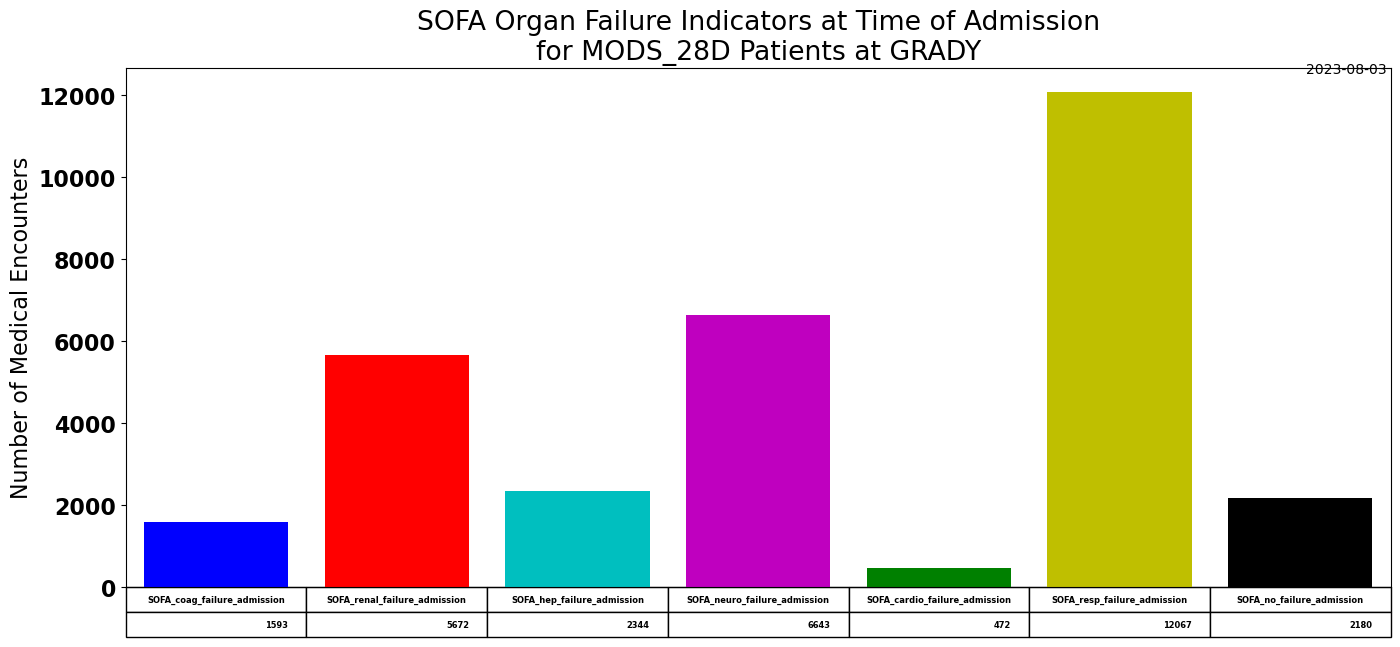

In [73]:
plt_title = (
f"""SOFA Organ Failure Indicators at Time of Admission
for MODS_28D Patients at {site_name.upper()}"""
)
plot_sofa_status(df=sepsis_admission_status, title=plt_title)

## 1-DAY POST SEPSIS
For patients who developed MODS within 28 days of sepsis onset:
1. discount organ failures present at admission:
1. determine the sequence of organ failure occuiring 24-hours post-sepsis
1. generate a timeseries of SoFA scores for the organs post-sepsis
1. use that time series for FSM (frequent subgraph mining)

#### Data

In [62]:
%%time
%%sql
sepsis_1D_df_pd << SELECT {patient_id},
                            {service_id},
                            {hospital_encounter_current},
                            hours_after_sepsis,
                            SOFA_coag,
                            SOFA_renal,
                            SOFA_hep,
                            SOFA_neuro,
                            SOFA_cardio,
                            SOFA_cardio_mod,
                            SOFA_resp,
                            SOFA_resp_sa,
                            SOFA_hourly_total,
                            SOFA_delta_24h,
                            SOFA_hourly_total_mod,
                            SOFA_delta_24h_mod,
                            first_sep3_SOFA,
                            first_sep3_time,
                            first_sep3_susp_mod,
                            first_sep3_SOFA_mod,
                            first_sep3_time_mod
                    FROM {site_name}_sepsis_1day
                                    WHERE admission_year IN (2016,2017,2018,2019,2020);

Returning data to local variable sepsis_1D_df_pd
CPU times: user 3.56 s, sys: 248 ms, total: 3.81 s
Wall time: 3.67 s


In [63]:
##### Move dataframe into Modin
sepsis_1D_df = md.DataFrame(sepsis_1D_df_pd)
#del(sepsis_admission_df_pd)

#### Sort and Index

In [64]:
sepsis_1D_df = index_1D(input_df=sepsis_1D_df, service_id=service_id, col_name=time_col)

# Increment down the time index by 1
sepsis_1D_df.reset_index(level=1, inplace=True)
sepsis_1D_df[time_col] = sepsis_1D_df[time_col] - 1
sepsis_1D_df.set_index([sepsis_1D_df.index, time_col], inplace=True)

#### Normalize

In [65]:
sepsis_1D_df = normalize_sofa_scores(sepsis_1D_df, cols=sofa_organ_cols)

#### Label MODS patients

In [66]:
sepsis_1D_df[mods_label] = sepsis_1D_df.index.get_level_values(0).isin(serviceIDs_mods_28D.tolist())

#### SOFA Status Check

In [67]:
sepsis_1D_df = sofa_status_check(sepsis_1D_df, sofa_score_cols, sofa_failure_cols)

#### Analyze SOFA Status

In [68]:
sepsis_1D_status = sepsis_1D_df[sofa_status_cols]

In [69]:
sepsis_1D_status.head()

SOFA_coag_failure  SOFA_renal_failure  SOFA_hep_failure  \
csn        time_1D                                                            
1015752680 0                    False               False              True   
           1                    False               False              True   
           2                    False               False              True   
           3                    False               False              True   
           4                    False               False              True   

                    SOFA_neuro_failure  SOFA_cardio_failure  \
csn        time_1D                                            
1015752680 0                     False                False   
           1                     False                False   
           2                     False                False   
           3                     False                False   
           4                     False                False   

                    SOFA_resp_failure  SOFA_no_failure  
csn        time_1D                                      
1015752680 0                    False            False  
           1                    False            False  
           2                    False            False  
           3                    False            False  
           4                    False            False

In [70]:
sepsis_admission_status.head()

,SOFA_coag_failure_admission,SOFA_renal_failure_admission,SOFA_hep_failure_admission,SOFA_neuro_failure_admission,SOFA_cardio_failure_admission,SOFA_resp_failure_admission,SOFA_no_failure_admission
csn,,,,,,,
1015752680,False,False,True,False,False,False,False
1015788298,False,False,True,False,False,False,False
1015788546,False,False,True,False,False,False,False
1015788896,False,False,True,False,False,False,False
1015789329,False,False,True,False,False,False,False


In [76]:
# Ignore any organs that were in failure at the time of admission
sepsis_1D_status = sepsis_1D_status.join(sepsis_admission_status, how='inner', on=['csn'])

#### Plot Organ Failure

In [78]:
failure_data = sepsis_1D_df[sofa_failure_cols].astype(int).copy()
failure_reference = sepsis_admission_df[sofa_failure_cols].groupby(service_id).first().copy()

In [79]:
service_ids = failure_reference.index
sampled_id = np.random.choice(service_ids, 1, replace=False)

In [80]:
failure_data.loc[sampled_id]

,SOFA_coag_failure,SOFA_renal_failure,SOFA_hep_failure,SOFA_neuro_failure,SOFA_cardio_failure,SOFA_resp_failure
time_1D,,,,,,
0,0,1,1,1,0,0
1,0,1,1,0,0,0
2,0,1,1,0,0,0
3,0,1,1,0,0,0
4,0,1,1,0,0,0
5,0,1,1,0,0,0
6,0,1,1,0,0,0
7,0,1,1,0,0,0
8,0,1,1,0,0,0


# Export for Mining

In [83]:
data_path = Path(f"/opt/scratchspace/KLAB_SAIL/MODSPhenotypes/data/{run_id}/")

sepsis_1D_df[sofa_score_cols].query('time_1D <= 24').to_parquet(data_path/f"{site_name}_{run_id}_sofa_scores_df.parquet")

---
***TODO***
# Determine the Sequence of Organ Failures